## Load model parameter from functa (jax)

In [1]:
import dill
import os

In [45]:
ROOT_PATH = '/home/tackgeun/inr-diff/functa/'
# Load params of LatentModulatedSiren model
# choose one of 64, 128, 256, 512, 1024
mod_dim = 1024
## Download pretrained weights
os.environ['MOD_DIM'] = str(mod_dim)
## Load pretrained weights
path = f'{ROOT_PATH}/celeba_params_{mod_dim}_latents.npz'
with open(path, 'rb') as f:
    ckpt = dill.load(f)
params = ckpt['params']
config = ckpt['config']
assert config['model']['type'] == 'latent_modulated_siren'
print(f'Loaded params for model with {mod_dim} latent dimensions.')

Loaded params for model with 1024 latent dimensions.


In [3]:
print('parameter name from functa model (jax)')
for k in params.keys():
    if 'w' in params[k]:
        print(k, params[k]['w'].shape, params[k]['b'].shape)
    else:
        print(k)

latent_modulated_siren/modulated_siren_layer/linear (2, 512) (512,)
latent_modulated_siren/modulated_siren_layer_1/linear (512, 512) (512,)
latent_modulated_siren/modulated_siren_layer_10/linear (512, 512) (512,)
latent_modulated_siren/modulated_siren_layer_11/linear (512, 512) (512,)
latent_modulated_siren/modulated_siren_layer_12/linear (512, 512) (512,)
latent_modulated_siren/modulated_siren_layer_13/linear (512, 512) (512,)
latent_modulated_siren/modulated_siren_layer_14/linear (512, 512) (512,)
latent_modulated_siren/modulated_siren_layer_15/linear (512, 512) (512,)
latent_modulated_siren/modulated_siren_layer_16/linear (512, 512) (512,)
latent_modulated_siren/modulated_siren_layer_17/linear (512, 512) (512,)
latent_modulated_siren/modulated_siren_layer_18/linear (512, 512) (512,)
latent_modulated_siren/modulated_siren_layer_19/linear (512, 3) (3,)
latent_modulated_siren/modulated_siren_layer_2/linear (512, 512) (512,)
latent_modulated_siren/modulated_siren_layer_3/linear (512, 51

### jax $\rightarrow$ pytorch parser

In [39]:
new_params = dict()
for k in params.keys():
    if 'latent_vector' in k:
        new_params['context_params'] = torch.FloatTensor(params[k]['latent_vector'])
    elif 'latent_to_modulation' in k:
        new_params['latent_to_modulation.mlp.0.weight'] = torch.FloatTensor(params[k]['w'].transpose())
        new_params['latent_to_modulation.mlp.0.bias'] = torch.FloatTensor(params[k]['b'].transpose())
    elif 'modulated_siren_layer' in k:       
        if any(map(str.isdigit, k)):
            i = int(k.split('_layer_')[1].split('/linear')[0])
        else:
            i = 0
        new_params[f'modsiren.{i}.w.weight'] = torch.FloatTensor(params[k]['w'].transpose())
        new_params[f'modsiren.{i}.w.bias'] = torch.FloatTensor(params[k]['b'].transpose())

modsiren.0.w.weight torch.Size([512, 2])
modsiren.1.w.weight torch.Size([512, 512])
modsiren.10.w.weight torch.Size([512, 512])
modsiren.11.w.weight torch.Size([512, 512])
modsiren.12.w.weight torch.Size([512, 512])
modsiren.13.w.weight torch.Size([512, 512])
modsiren.14.w.weight torch.Size([512, 512])
modsiren.15.w.weight torch.Size([512, 512])
modsiren.16.w.weight torch.Size([512, 512])
modsiren.17.w.weight torch.Size([512, 512])
modsiren.18.w.weight torch.Size([512, 512])
modsiren.19.w.weight torch.Size([3, 512])
modsiren.2.w.weight torch.Size([512, 512])
modsiren.3.w.weight torch.Size([512, 512])
modsiren.4.w.weight torch.Size([512, 512])
modsiren.5.w.weight torch.Size([512, 512])
modsiren.6.w.weight torch.Size([512, 512])
modsiren.7.w.weight torch.Size([512, 512])
modsiren.8.w.weight torch.Size([512, 512])
modsiren.9.w.weight torch.Size([512, 512])


## modulation vector test in pytorch

In [173]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

import dataio, meta_modules, utils, training, loss_functions

In [84]:
model = meta_modules.LatentModulatedSiren(width=512, depth=20, latent_dim=mod_dim, latent_vector_type='instance')

In [85]:
model.load_state_dict(new_params)

<All keys matched successfully>

In [86]:
path = f'{ROOT_PATH}/celeba_modulations_{mod_dim}_latents.npz'
with open(path, 'rb') as f:
    data = dill.load(f)
    train_dict = data['train']
    test_dict = data['test']
bs = 9
test_mods = test_dict['modulation'][:bs]

In [178]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.'''
    if isinstance(sidelen, int):
        sidelen = dim * (sidelen,)

    if dim == 2:
        pixel_coords = np.stack(np.mgrid[:sidelen[0], :sidelen[1]], axis=-1)[None, ...].astype(np.float32)
        pixel_coords[0, :, :, 0] = pixel_coords[0, :, :, 0] / (sidelen[0] - 1)
        pixel_coords[0, :, :, 1] = pixel_coords[0, :, :, 1] / (sidelen[1] - 1)
    elif dim == 3:
        pixel_coords = np.stack(np.mgrid[:sidelen[0], :sidelen[1], :sidelen[2]], axis=-1)[None, ...].astype(np.float32)
        pixel_coords[..., 0] = pixel_coords[..., 0] / max(sidelen[0] - 1, 1)
        pixel_coords[..., 1] = pixel_coords[..., 1] / (sidelen[1] - 1)
        pixel_coords[..., 2] = pixel_coords[..., 2] / (sidelen[2] - 1)
    else:
        raise NotImplementedError('Not implemented for dim=%d' % dim)

    #pixel_coords -= 0.5
    #pixel_coords *= 2.
    pixel_coords = torch.Tensor(pixel_coords).view(-1, dim)
    return pixel_coords


def show(imgs, ncols=None):
    if ncols == None:
        ncols = len(imgs)

    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=ncols, squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [201]:
image_resolution = 64

mgrid = get_mgrid((image_resolution, image_resolution))
mgrid = mgrid.unsqueeze(0)
mgrid = mgrid.repeat(bs, 1, 1)

In [202]:
model.context_params = torch.nn.Parameter(torch.FloatTensor(test_mods))
inputs = {'coords': mgrid}
outputs = model(inputs)
im_batch = outputs['model_out'].view(-1, 64, 64, 3).permute(0,1,2,3).detach().numpy()

### visualize examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


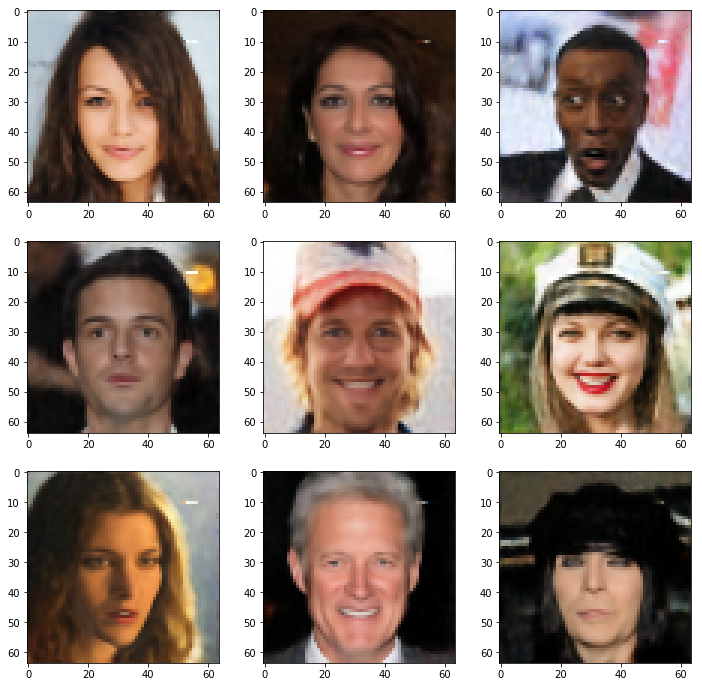

In [204]:
plt.rcParams["savefig.bbox"] = 'tight'
gridsize = int(np.floor(np.sqrt(bs)))
figsize = 4
fig, ax = plt.subplots(figsize=(gridsize * figsize, gridsize * figsize))
plt.axis('off')
for i, img in enumerate(im_batch):
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    
plt.show()

In [191]:
img.shape

(3, 64, 64)